In [1]:
# !pip install oolearning --upgrade

In [32]:
import math
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import oolearning as oo
from helpers import DataFrameSelector, CustomLogTransform, ChooserTransform, CombineAgeHoursTransform, CombineCapitalGainLossTransform

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
working_directory = os.path.join(os.getcwd(), '../')
csv_file = os.path.join(working_directory, 'census.csv')
target_variable = 'income'
positive_class = '>50K'
negative_class = '<=50K'

#target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
 #                                                  map_numeric_target=target_mapping)

# look at data
explore.dataset.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
age,45222,0,0.0,0,0.000,38.548,13.218,0.343,0.533,-0.156,17.0,22.0,28.0,37.0,47.0,57.0,90.0
education-num,45222,0,0.0,0,0.000,10.118,2.553,0.252,-0.311,0.635,1.0,7.0,9.0,10.0,13.0,13.0,16.0
capital-gain,45222,0,0.0,41432,0.916,1101.430,7506.430,6.815,11.789,150.151,0.0,0.0,0.0,0.0,0.0,0.0,99999.0
capital-loss,45222,0,0.0,43082,0.953,88.595,404.956,4.571,4.516,19.364,0.0,0.0,0.0,0.0,0.0,0.0,4356.0
hours-per-week,45222,0,0.0,0,0.000,40.938,12.008,0.293,0.341,3.201,1.0,25.0,40.0,40.0,45.0,55.0,99.0


In [5]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
workclass,45222,0,0.0,Private,7,0.000
education_level,45222,0,0.0,HS-grad,16,0.000
marital-status,45222,0,0.0,Married-civ-spouse,7,0.000
occupation,45222,0,0.0,Craft-repair,14,0.000
relationship,45222,0,0.0,Husband,6,0.000
race,45222,0,0.0,White,5,0.000
sex,45222,0,0.0,Male,2,0.000
native-country,45222,0,0.0,United-States,41,0.001
income,45222,0,0.0,<=50K,2,0.000


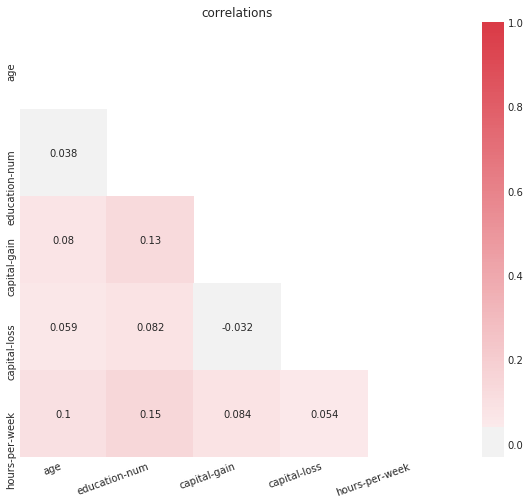

In [6]:
explore.plot_correlation_heatmap()

In [7]:
# NOTE: since I will be cross-validating transformations e.g. GridSearchCV, it typically won't work to
# one-hot-encode during cross-validation because the holdout fold will tend to have categoric values that
# weren't found in the training folds, and therefore will break during transformation because it will encode
# a value (i.e. add a column) that didn't exist in the training folds.
# So, for this, we need to fit ALL data. Then, below if we have new data e.g. Kaggle, we have to apply
# the same pipeline (i.e.  cat_encoding_pipeline.transform()
# TODO: this breaks though if there are any categorical features with missing values in the final test/Kaggle set
one_hot_transformer = oo.DummyEncodeTransformer(encoding=oo.CategoricalEncoding.ONE_HOT)
transformed_data = one_hot_transformer.fit_transform(explore.dataset.drop(columns=target_variable))
transformed_data[target_variable] = explore.dataset[target_variable]

# Transformations & Transformation Tuning Parameters

define the transformations we want to do, some transformations will have parameters (e.g. base of log tranform (or no transform), type of scaling, whether or not to add column combinations (e.g. age * hours-per-week)

Below is the pipeline for captail-gain/lost. 

We want to tune whether or not we should log transform. We need to do this after imputing but before scaling, so it needs to be it's own pipeline.

In [8]:
cap_gain_loss_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['capital-gain', 'capital-loss'])),
        ('imputer', Imputer()),
        # tune Log trasformation base (or no transformation); update: tuned - chose base e
        ('custom_transform', CustomLogTransform(base=math.e)),
        # tune "net gain" (have to do it after log transform; log of <=0 doesn't exist)
        ('custom_cap_gain_minus_loss', CombineCapitalGainLossTransform(combine=True)),
        # tune MinMax vs StandardScaler; we chose MinMax; update: tuned - chose MinMax
        ('custom_scaler', ChooserTransform(base_transformer=MinMaxScaler())),
    ])

Below is the pipeline for the rest of numeric features:

In [9]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['age', 'education-num', 'hours-per-week'])),
        ('imputer', Imputer()),
        # tune age * hours-per-week; update: tuned -chose not to include
        #('combine_agehours', CombineAgeHoursTransform()),
        # tune MinMax vs StandardScaler; update: tuned - chose MinMax
        ('custom_scaler', ChooserTransform(base_transformer=MinMaxScaler())),
    ])

Pipeline that simply gets the categorical/encoded columns from the previous transformation (which used `oo-learning`)

In [10]:
append_categoricals = Pipeline([
        ('append_cats', DataFrameSelector(attribute_names=one_hot_transformer.encoded_columns))  # already encoded
    ])

Below is the pipeline for combining all of the other pipelines

In [11]:
# combine pipelines
transformations_pipeline = FeatureUnion(transformer_list=[
        ("cap_gain_loss_pipeline", cap_gain_loss_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", append_categoricals),
    ])

Choose the transformations to tune, below:

In [12]:
model = RandomForestClassifier(
                      random_state=42,        
                      #oob_score=True,
                      #criterion="gini",
#                       max_features="auto",
#                       n_estimators=10,                  
#                       max_depth=None,
#                       min_samples_split=2,
#                       min_samples_leaf=1,
#                       min_weight_fraction_leaf=0.,
#                       max_leaf_nodes=None,
#                       min_impurity_decrease=0.,
#                       min_impurity_split=None,
                      
    
                     )

In [13]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    #('pca_chooser', ChooserTransform()),  # PCA option lost; didn't include
    #('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('model', model)
])

Tuning strategy according to https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [14]:
from scipy.stats import randint, uniform, expon
model_param_dict = {
        'model__max_features': uniform(.2, .8),
        'model__n_estimators': randint(50, 2000),
        'model__max_depth': randint(3, 100),
        'model__min_samples_split': uniform(0.001, 0.4),
        'model__min_samples_leaf': uniform(0.001, 0.4),
}

In [15]:
# actual hyper-parameters/options to tune for transformations.
transformation_parameters = {
         #'preparation__cap_gain_loss_pipeline__custom_transform__base': [None, math.e],  # Log transform (base e) or not
         #'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': [True, False],
         #'preparation__cap_gain_loss_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],
         #'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],  # tune strategy
         #'preparation__num_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],
         #'preparation__num_pipeline__combine_agehours__combine': [True, False],
         #'pca_chooser__base_transformer': [PCA(n_components=0.95, random_state=42), None],  # PCA vs not
         
    }

In [16]:
param_grid = {**transformation_parameters, **model_param_dict}
param_grid

{'model__max_features': <scipy.stats._distn_infrastructure.rv_frozen at 0x1062421d0>,
 'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x106242e10>,
 'model__max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x1062425c0>,
 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x106242b70>,
 'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x106266208>}

In [17]:
# def binary_roc_auc(y_true, y_score):
#     return roc_auc_score(y_true=y_true,
#                          # binary makes it so it converts the "scores" to predictions
#                          y_score=[1 if x > 0.5 else 0 for x in y_score])

scorer = make_scorer(roc_auc_score, greater_is_better=True)

In [18]:
y =  transformed_data[target_variable].apply(lambda x: 1 if x == positive_class else 0)

In [19]:
transformed_data[target_variable].values[0:10]

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K',
       '>50K', '>50K', '>50K'], dtype=object)

In [20]:
y[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

In [21]:
print('Starting....')
time_start = time.time()
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=full_pipeline,
                                 param_distributions=param_grid,
                                 n_iter=40,
                                 cv=RepeatedKFold(n_splits=5, n_repeats=1),
                                 scoring=scorer,
                                 return_train_score=True,
                                 n_jobs=-1,
                                 verbose=2)
grid_search.fit(transformed_data.drop(columns=target_variable), y)
time_end = time.time()

Starting....
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] model__max_depth=31, model__max_features=0.8268839266552601, model__min_samples_leaf=6, model__min_samples_split=2, model__n_estimators=614 
[CV] model__max_depth=31, model__max_features=0.8268839266552601, model__min_samples_leaf=6, model__min_samples_split=2, model__n_estimators=614 
[CV] model__max_depth=31, model__max_features=0.8268839266552601, model__min_samples_leaf=6, model__min_samples_split=2, model__n_estimators=614 
[CV] model__max_depth=31, model__max_features=0.8268839266552601, model__min_samples_leaf=6, model__min_samples_split=2, model__n_estimators=614 
[CV] model__max_depth=31, model__max_features=0.8268839266552601, model__min_samples_leaf=6, model__min_samples_split=2, model__n_estimators=614 
[CV] model__max_depth=57, model__max_features=0.6634777723233736, model__min_samples_leaf=12, model__min_samples_split=9, model__n_estimators=1990 
[CV] model__max_depth=57, model__max_features=0

[CV] model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452 
[CV]  model__max_depth=46, model__max_features=0.3267419200887751, model__min_samples_leaf=9, model__min_samples_split=10, model__n_estimators=1162, total= 7.2min
[CV] model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452 
[CV]  model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452, total= 4.1min
[CV] model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452 


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 56.1min


[CV]  model__max_depth=93, model__max_features=0.5798939954369224, model__min_samples_leaf=3, model__min_samples_split=14, model__n_estimators=1810, total=21.1min
[CV] model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452 
[CV]  model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452, total= 4.0min
[CV] model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452 
[CV]  model__max_depth=79, model__max_features=0.5158825326984933, model__min_samples_leaf=14, model__min_samples_split=2, model__n_estimators=452, total= 4.2min
[CV] model__max_depth=36, model__max_features=0.9435257048037449, model__min_samples_leaf=12, model__min_samples_split=6, model__n_estimators=290 
[CV]  model__max_depth=96, model__max_features=0.4087148680294206, model

[CV] model__max_depth=25, model__max_features=0.8312208426881189, model__min_samples_leaf=13, model__min_samples_split=16, model__n_estimators=709 
[CV]  model__max_depth=71, model__max_features=0.44276769426590046, model__min_samples_leaf=12, model__min_samples_split=14, model__n_estimators=1460, total=12.1min
[CV] model__max_depth=60, model__max_features=0.6495536649513012, model__min_samples_leaf=14, model__min_samples_split=3, model__n_estimators=1719 
[CV]  model__max_depth=25, model__max_features=0.8312208426881189, model__min_samples_leaf=13, model__min_samples_split=16, model__n_estimators=709, total=10.8min
[CV] model__max_depth=60, model__max_features=0.6495536649513012, model__min_samples_leaf=14, model__min_samples_split=3, model__n_estimators=1719 
[CV]  model__max_depth=71, model__max_features=0.44276769426590046, model__min_samples_leaf=12, model__min_samples_split=14, model__n_estimators=1460, total=14.0min
[CV] model__max_depth=60, model__max_features=0.649553664951301

[CV]  model__max_depth=39, model__max_features=0.8216408049669899, model__min_samples_leaf=10, model__min_samples_split=5, model__n_estimators=1134, total=14.1min
[CV] model__max_depth=36, model__max_features=0.4544809813980024, model__min_samples_leaf=11, model__min_samples_split=12, model__n_estimators=732 
[CV]  model__max_depth=39, model__max_features=0.8216408049669899, model__min_samples_leaf=10, model__min_samples_split=5, model__n_estimators=1134, total=14.3min
[CV] model__max_depth=36, model__max_features=0.4544809813980024, model__min_samples_leaf=11, model__min_samples_split=12, model__n_estimators=732 
[CV]  model__max_depth=96, model__max_features=0.8162250465927565, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1708, total=24.3min
[CV] model__max_depth=36, model__max_features=0.4544809813980024, model__min_samples_leaf=11, model__min_samples_split=12, model__n_estimators=732 
[CV]  model__max_depth=96, model__max_features=0.8162250465927565, m

[CV] model__max_depth=41, model__max_features=0.7489990519209795, model__min_samples_leaf=12, model__min_samples_split=16, model__n_estimators=1898 
[CV]  model__max_depth=69, model__max_features=0.4946876771386959, model__min_samples_leaf=5, model__min_samples_split=9, model__n_estimators=978, total= 8.5min
[CV] model__max_depth=41, model__max_features=0.7489990519209795, model__min_samples_leaf=12, model__min_samples_split=16, model__n_estimators=1898 
[CV]  model__max_depth=69, model__max_features=0.4946876771386959, model__min_samples_leaf=5, model__min_samples_split=9, model__n_estimators=978, total= 8.2min
[CV] model__max_depth=41, model__max_features=0.7489990519209795, model__min_samples_leaf=12, model__min_samples_split=16, model__n_estimators=1898 
[CV]  model__max_depth=69, model__max_features=0.4946876771386959, model__min_samples_leaf=5, model__min_samples_split=9, model__n_estimators=978, total= 8.4min
[CV] model__max_depth=34, model__max_features=0.6158717241085936, mode

[CV]  model__max_depth=53, model__max_features=0.3636390672114413, model__min_samples_leaf=7, model__min_samples_split=18, model__n_estimators=1824, total=11.7min
[CV] model__max_depth=8, model__max_features=0.4350975617709967, model__min_samples_leaf=19, model__min_samples_split=14, model__n_estimators=1292 
[CV]  model__max_depth=53, model__max_features=0.3636390672114413, model__min_samples_leaf=7, model__min_samples_split=18, model__n_estimators=1824, total=11.9min
[CV] model__max_depth=10, model__max_features=0.3535997492585498, model__min_samples_leaf=4, model__min_samples_split=11, model__n_estimators=1534 
[CV]  model__max_depth=53, model__max_features=0.3636390672114413, model__min_samples_leaf=7, model__min_samples_split=18, model__n_estimators=1824, total=12.2min
[CV] model__max_depth=10, model__max_features=0.3535997492585498, model__min_samples_leaf=4, model__min_samples_split=11, model__n_estimators=1534 
[CV]  model__max_depth=53, model__max_features=0.3636390672114413, 

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 238.2min


[CV]  model__max_depth=68, model__max_features=0.3784068673874497, model__min_samples_leaf=15, model__min_samples_split=3, model__n_estimators=1671, total=15.0min
[CV] model__max_depth=68, model__max_features=0.3784068673874497, model__min_samples_leaf=15, model__min_samples_split=3, model__n_estimators=1671 
[CV]  model__max_depth=68, model__max_features=0.3784068673874497, model__min_samples_leaf=15, model__min_samples_split=3, model__n_estimators=1671, total=14.7min
[CV] model__max_depth=32, model__max_features=0.8582330106025275, model__min_samples_leaf=6, model__min_samples_split=3, model__n_estimators=546 
[CV]  model__max_depth=30, model__max_features=0.9912414410134738, model__min_samples_leaf=5, model__min_samples_split=15, model__n_estimators=1180, total=27.6min
[CV] model__max_depth=32, model__max_features=0.8582330106025275, model__min_samples_leaf=6, model__min_samples_split=3, model__n_estimators=546 
[CV]  model__max_depth=30, model__max_features=0.9912414410134738, mode

[CV] model__max_depth=64, model__max_features=0.3491138934298448, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=946 
[CV]  model__max_depth=78, model__max_features=0.37728594226460777, model__min_samples_leaf=16, model__min_samples_split=14, model__n_estimators=67, total=  24.7s
[CV] model__max_depth=64, model__max_features=0.3491138934298448, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=946 
[CV]  model__max_depth=51, model__max_features=0.874600250312016, model__min_samples_leaf=14, model__min_samples_split=15, model__n_estimators=783, total=10.0min
[CV] model__max_depth=64, model__max_features=0.3491138934298448, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=946 
[CV]  model__max_depth=82, model__max_features=0.7953001268707112, model__min_samples_leaf=11, model__min_samples_split=11, model__n_estimators=813, total= 9.7min
[CV] model__max_depth=64, model__max_features=0.3491138934298448, model__m

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 285.6min finished


In [22]:
print('Time: {}m'.format(round((time_end-time_start)/60, 1)))

Time: 294.1m


In [27]:
results_df = pd.concat([pd.DataFrame({'mean_score': grid_search.cv_results_["mean_test_score"],
                                      'st_dev_score': grid_search.cv_results_["std_test_score"]}),
          pd.DataFrame(grid_search.cv_results_["params"])],
          axis=1)
results_df.sort_values(by=['mean_score'], ascending=False).head(10)

,mean_score,st_dev_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
5,0.787030,0.006113,96,0.408715,2,16,1815
20,0.785735,0.006240,69,0.494688,5,9,978
3,0.785671,0.005792,93,0.579894,3,14,1810
36,0.785192,0.006304,64,0.349114,8,5,946
25,0.784941,0.006313,53,0.363639,7,18,1824
24,0.784935,0.005835,32,0.334000,8,4,1778
0,0.784916,0.006188,31,0.826884,6,2,614
4,0.784698,0.006017,46,0.326742,9,10,1162
23,0.784548,0.006103,34,0.615872,4,11,529
31,0.784494,0.005930,32,0.858233,6,3,546


In [74]:
grid_search.best_score_, grid_search.best_params_

(0.7870297833559529,
 {'model__max_depth': 96,
  'model__max_features': 0.4087148680294206,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 16,
  'model__n_estimators': 1815})

In [75]:
rescaled_means = MinMaxScaler(feature_range=(100, 1000)).fit_transform(results_df['mean_score'].values.reshape(-1, 1))
rescaled_means = rescaled_means.flatten()  # reshape back to array
#rescaled_means

In [76]:
def compare_two_parameters(x_label, y_label):
    x = results_df[x_label]
    y = results_df[y_label]            
            
    plt.scatter(x,y,c=rescaled_means, s=rescaled_means, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    index_of_best = np.argmax(rescaled_means)
    plt.scatter(x[index_of_best], y[index_of_best], marker= 'x', s=200, color='red')

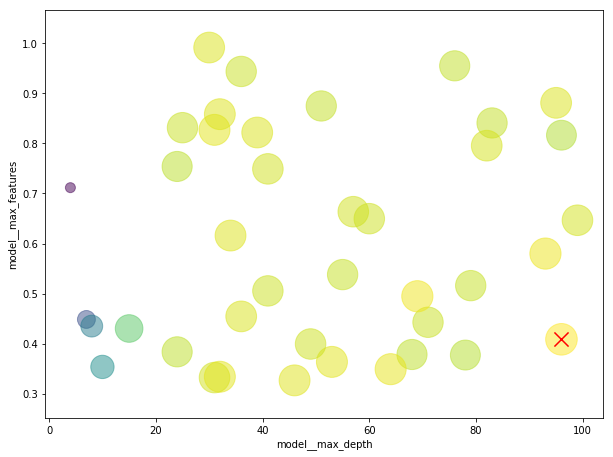

In [77]:
x_label = 'model__max_depth'
y_label = 'model__max_features'
compare_two_parameters(x_label, y_label)

In [68]:
grid_search.best_score_, grid_search.best_params_

(0.7870297833559529,
 {'model__max_depth': 96,
  'model__max_features': 0.4087148680294206,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 16,
  'model__n_estimators': 1815})

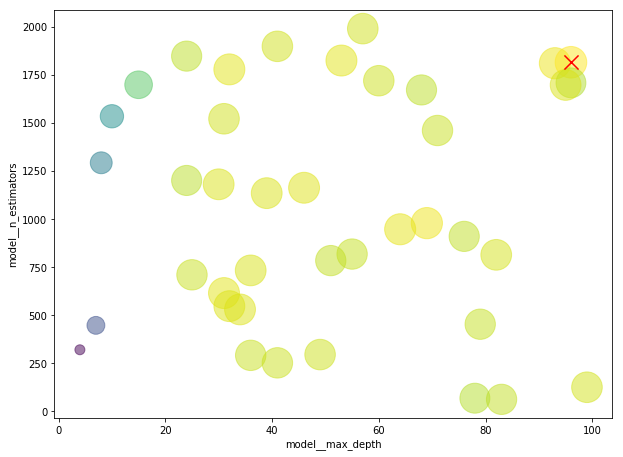

In [69]:
x_label = 'model__max_depth'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [70]:
grid_search.best_score_, grid_search.best_params_

(0.7870297833559529,
 {'model__max_depth': 96,
  'model__max_features': 0.4087148680294206,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 16,
  'model__n_estimators': 1815})

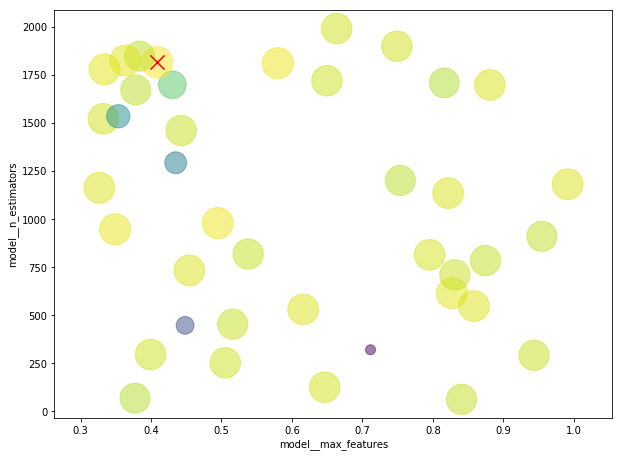

In [71]:
x_label = 'model__max_features'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [70]:
grid_search.best_score_, grid_search.best_params_

(0.7870297833559529,
 {'model__max_depth': 96,
  'model__max_features': 0.4087148680294206,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 16,
  'model__n_estimators': 1815})

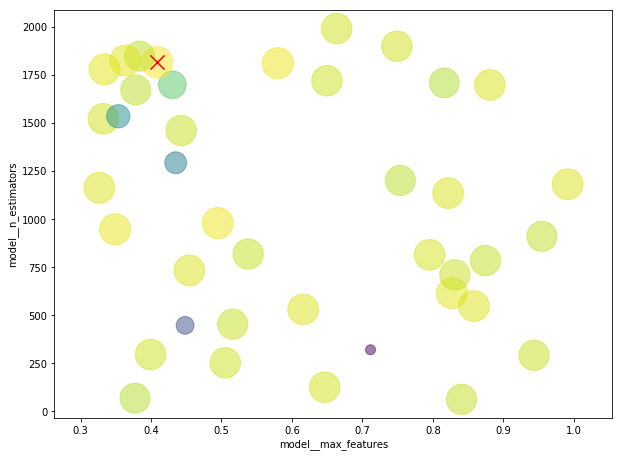

In [71]:
x_label = 'model__max_features'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

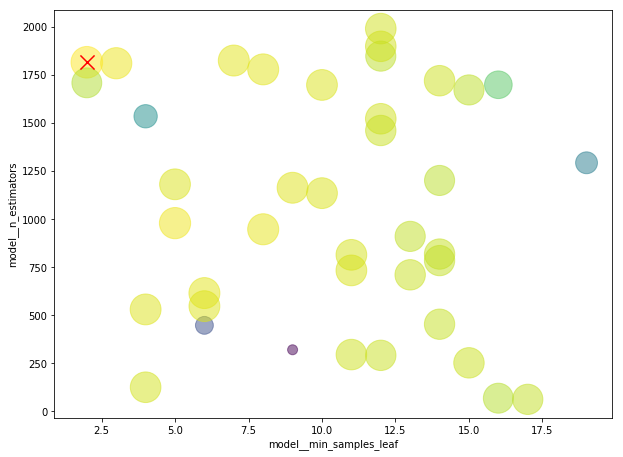

In [78]:
x_label = 'model__min_samples_leaf'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

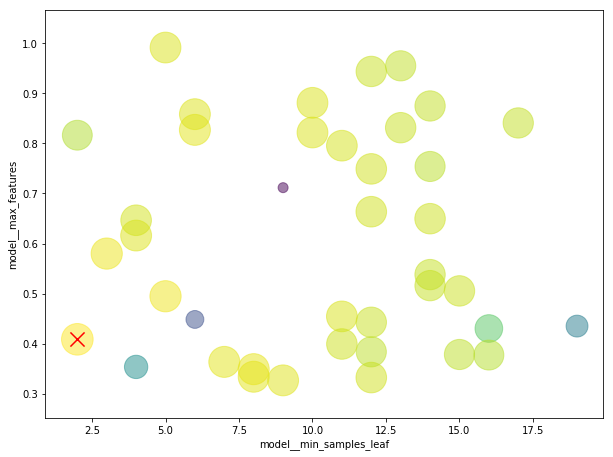

In [79]:
x_label = 'model__min_samples_leaf'
y_label = 'model__max_features'
compare_two_parameters(x_label, y_label)

In [70]:
grid_search.best_score_, grid_search.best_params_

(0.7870297833559529,
 {'model__max_depth': 96,
  'model__max_features': 0.4087148680294206,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 16,
  'model__n_estimators': 1815})

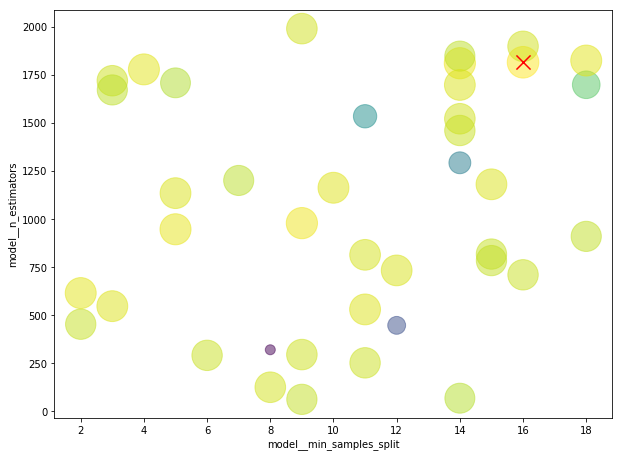

In [80]:
x_label = 'model__min_samples_split'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

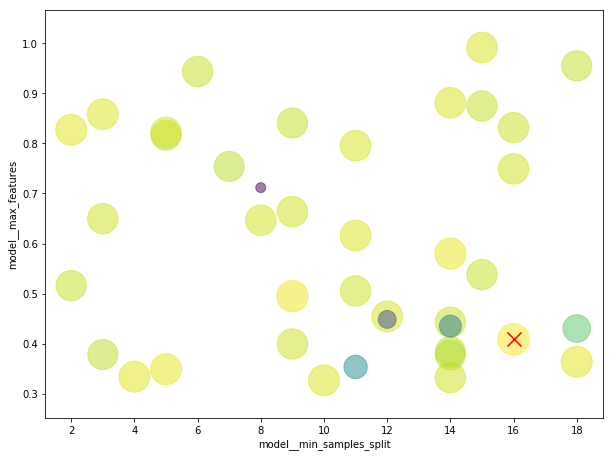

In [81]:
x_label = 'model__min_samples_split'
y_label = 'model__max_features'
compare_two_parameters(x_label, y_label)

In [70]:
grid_search.best_score_, grid_search.best_params_

(0.7870297833559529,
 {'model__max_depth': 96,
  'model__max_features': 0.4087148680294206,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 16,
  'model__n_estimators': 1815})

reference:

```
N = 1000
r = range(0, N)
x = r
y = r
colors = r
area = r

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()
```

In [39]:
# column order is based off of the pipeline and FeatureUnion
    # cap_gain_loss_pipeline
    # num_pipeline
    # cat_pipeline
features = ['capital-gain', 'capital-loss'] + ['Net Capital'] + ['age', 'education-num', 'hours-per-week'] + one_hot_transformer.encoded_columns
importances = grid_search.best_estimator_.steps[1][1].feature_importances_

In [40]:
import pandas as pd
pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
31,marital-status_Married-civ-spouse,0.172910
4,education-num,0.127972
2,Net Capital,0.121785
3,age,0.102911
0,capital-gain,0.091117
50,relationship_Husband,0.086288
5,hours-per-week,0.062201
1,capital-loss,0.029825
39,occupation_Exec-managerial,0.017801
55,relationship_Wife,0.014037
